# Hight GWAS fine-mapping

## Liftover

In [1]:
import pandas as pd
import numpy as np
import cugg
from cugg import liftover
lf = liftover.Liftover('hg19','hg38')
gwas = pd.read_csv("height_PC10_step2_imp.regenie_HEIGHT_inverserank.regenie_JAZF1",comment = "#",sep = " ")


In [2]:
gwas

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA
0,7,27869098,rs545409685,C,T,0.997338,0.921920,365920,ADD,-0.020502,0.013793,2.209410,0.862739,NaN
1,7,27869261,7:27869261_CAGTA_C,C,CAGTA,0.998504,0.847013,365920,ADD,0.010341,0.019221,0.289412,0.228708,NaN
2,7,27869377,rs73075348,G,A,0.943403,1.000000,365920,ADD,0.000331,0.002957,0.012549,0.040575,NaN
3,7,27869782,rs6948467,A,G,0.607201,0.993109,365920,ADD,-0.006317,0.001404,20.250800,5.167980,NaN
4,7,27869794,rs73075354,G,C,0.883848,0.994221,365920,ADD,0.013539,0.002140,40.038800,9.603850,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,7,28305583,rs142080139,C,T,0.980411,0.993345,365920,ADD,-0.014940,0.004946,9.125600,2.598500,NaN
2267,7,28305872,rs77166288,G,A,0.953204,0.961312,365920,ADD,0.005109,0.003299,2.398330,0.915548,NaN
2268,7,28306168,rs577794962,C,G,0.998276,0.807648,365920,ADD,-0.004818,0.018340,0.069008,0.100844,NaN
2269,7,28306169,rs494452,C,T,0.063266,0.979944,365920,ADD,0.006939,0.002835,5.991360,1.842360,NaN


In [3]:
gwas_POS = gwas.apply(lambda x:  lf.chrpos_liftover(x["CHROM"],x["GENPOS"]),axis = 1 )
gwas["GENPOS"] =  [x[1] for x in gwas_POS]
len(gwas.query("GENPOS == 0").index)

0

In [4]:
gwas_POS

0       (7, 27829479)
1       (7, 27829642)
2       (7, 27829758)
3       (7, 27830163)
4       (7, 27830175)
            ...      
2266    (7, 28265964)
2267    (7, 28266253)
2268    (7, 28266549)
2269    (7, 28266550)
2270    (7, 28266555)
Length: 2271, dtype: object

In [6]:
gwas.to_csv("height_PC10_step2_imp.regenie_HEIGHT_inverserank.regenie_JAZF1_liftedover_hg38",index = 0,sep = " ")

## Finemapping in R

In [213]:
library("reticulate")

In [214]:
GWAS = read_delim("height_PC10_step2_imp.regenie_HEIGHT_inverserank.regenie_JAZF1_liftedover_hg38"," ")

Rows: 2271 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr (4): ID, ALLELE0, ALLELE1, TEST
dbl (9): CHROM, GENPOS, A1FREQ, INFO, N, BETA, SE, CHISQ, LOG10P
lgl (1): EXTRA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


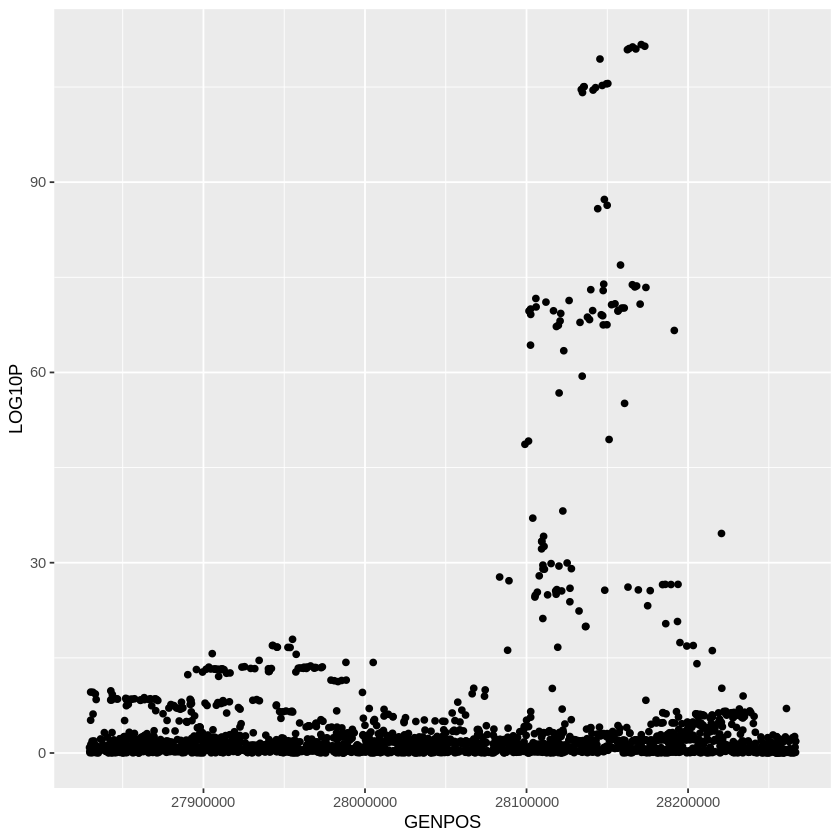

In [215]:
GWAS%>%ggplot(aes(x = GENPOS,  y = LOG10P ))+geom_point()

In [212]:
min(GWAS$GENPOS)
max(GWAS$GENPOS)

[1] 27869098

[1] 28306174

In [235]:
np <- import("numpy")

In [240]:
npz1 <- np$load("/mnt/vast/hpc/csg/molecular_phenotype_calling/LD/output/1300_hg38_EUR_LD_blocks_LD/ROSMAP_NIA_WGS.leftnorm.filtered.filtered.chr7_25641844_28408975.float16.npz",allow_pickle=T)


In [241]:
SNP = npz1[["arr_1"]]

In [237]:
npz1

In [248]:
GWAS_filtered = GWAS%>%mutate(variant  = paste0("chr",CHROM,":",GENPOS,"_",ALLELE1,"_",ALLELE0 ))%>%filter(variant %in% SNP)

In [250]:
LD = npz1[["arr_0"]]
colnames(LD) = rownames(LD) = SNP

In [253]:
LD_filtered = LD[intersect(SNP, GWAS_filtered$variant),intersect(SNP, GWAS_filtered$variant)]

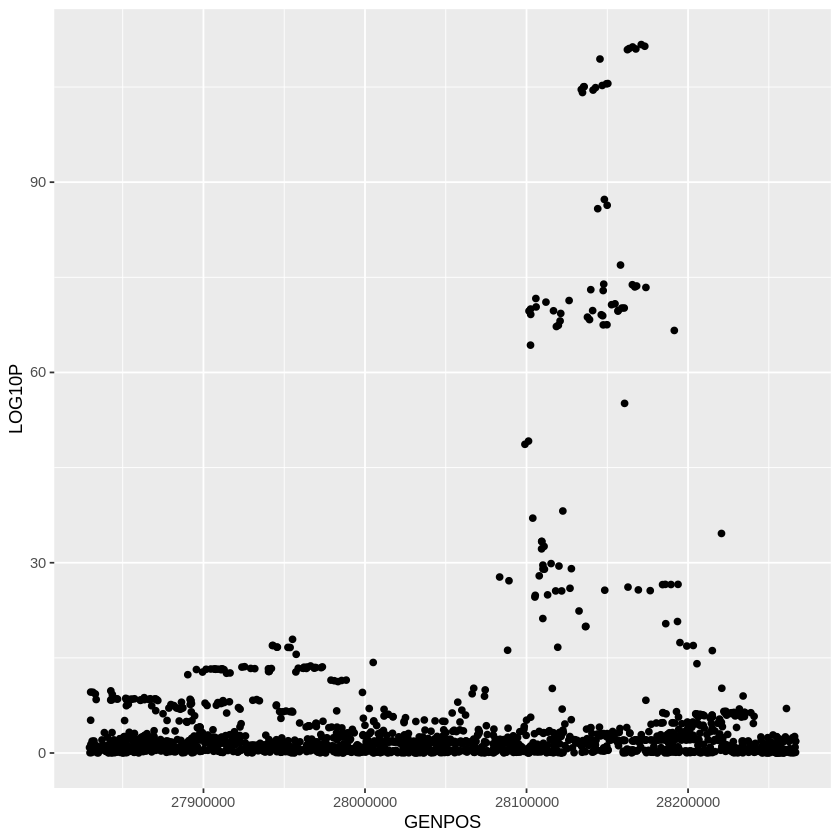

In [263]:
GWAS_filtered%>%ggplot(aes(x = GENPOS,  y = LOG10P ))+geom_point()

In [217]:
GWAS = GWAS%>%mutate(Z = BETA/SE)

In [ ]:
res = susieR:::susie_rss(as.matrix(GWAS_filtered%>%pull(Z)) ,R = LD_filtered,n = 365920  , z_ld_weight = 0, estimate_residual_variance = FALSE, 
    prior_variance = 50, check_prior = TRUE ,L = 10,verbose = TRUE, compute_univariate_zscore = TRUE )

SyntaxError: invalid syntax (4006526684.py, line 1)

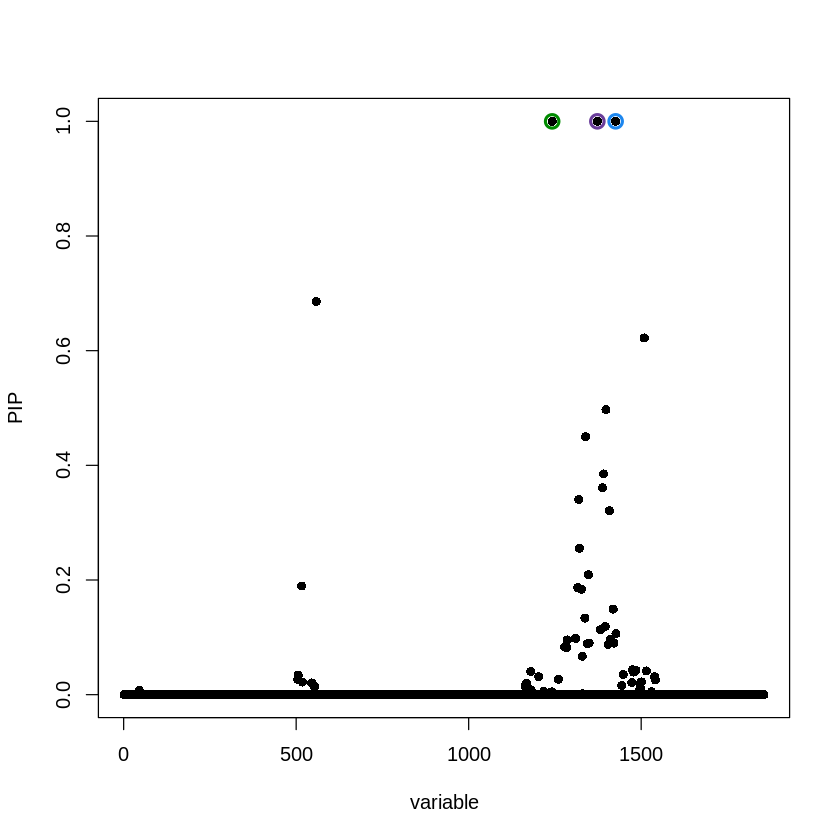

In [257]:
susie_plot(res,y = "PIP")

In [259]:
condz = susieR::kriging_rss(as.matrix(GWAS_filtered%>%pull(Z)) ,R = LD_filtered,n = 365920)

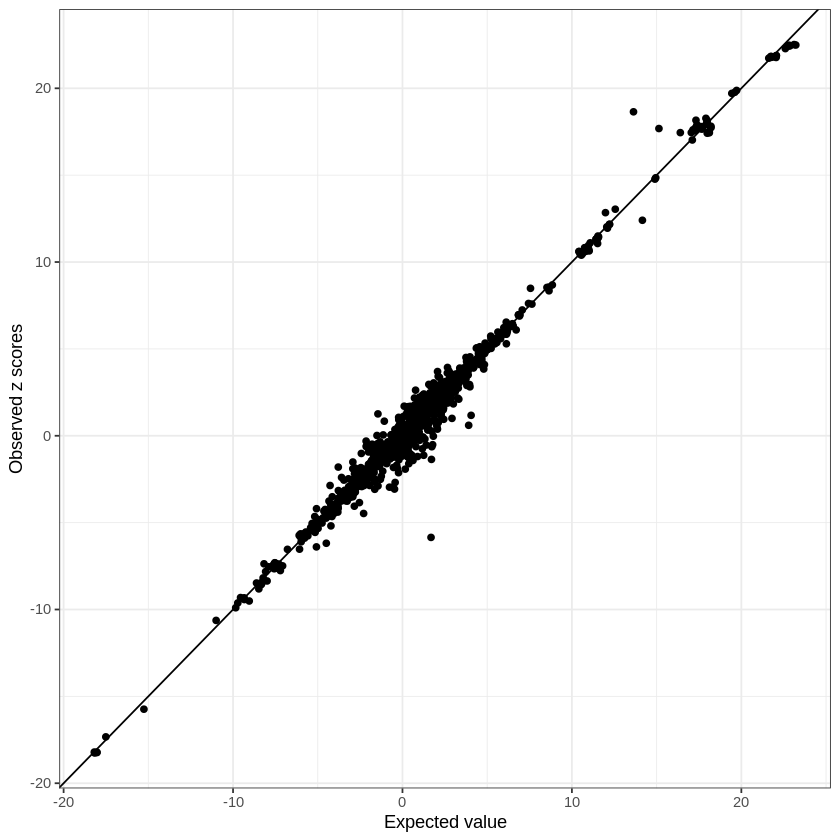

In [260]:
condz$plot

In [9]:
lf2 = liftover.Liftover('hg38','hg19')


In [12]:
gwas = pd.read_csv("JAZF1_pip_0.01.txt",comment = "#",sep = "\t")
gwas_POS = gwas.apply(lambda x:  lf.chrpos_liftover(x["chr"],x["pos"]),axis = 1 )
gwas["pos"] =  [x[1] for x in gwas_POS]
len(gwas.query("pos == 0").index)

0

In [14]:
gwas.to_csv("JAZF1_pip_0.01_hg19_.txt",sep = "\t")

## The non-overlifted version with waist population LD



In [7]:
library("dplyr")
library("readr")
library("susieR")
library("ggplot2")

In [8]:
gwas = read_delim("height_PC10_step2_imp.regenie_HEIGHT_inverserank.regenie_JAZF1")
new_LD = read_delim("/mnt/vast/hpc/csg/tf2478/2021/20211226_jazf1/working_jazf1_extractions/WAIST_extraction/7_27868573_28273990/UKB_caucasians_BMIwaisthip_AsthmaAndT2D_INT-WAIST_withagesex_042020_rankNorm_WAIST.boltlmm.snp_stats_7_27868573_28273990.population_ld")
rownames(new_LD) = colnames(new_LD)
GWAS_filtered = gwas%>%mutate(variant  = paste0(CHROM,"_",GENPOS,"_",ALLELE0,"_",ALLELE1 ))%>%filter(variant %in% colnames(new_LD))
GWAS_filtered = GWAS_filtered%>%mutate(Z = BETA/SE)
new_LD_filtered =as.matrix(new_LD)[GWAS_filtered$variant,GWAS_filtered$variant]
res10_waist = susieR:::susie_rss(as.matrix(GWAS_filtered%>%pull(Z)) ,
                                 R = new_LD_filtered,n = 365920  , estimate_residual_variance = FALSE, 
    prior_variance = 50, check_prior = TRUE ,L = 10,verbose = TRUE, compute_univariate_zscore
                                 = TRUE )

Rows: 2271 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr (4): ID, ALLELE0, ALLELE1, TEST
dbl (9): CHROM, GENPOS, A1FREQ, INFO, N, BETA, SE, CHISQ, LOG10P
lgl (1): EXTRA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2549 Columns: 2549
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2549): 7_27869098_C_T, 7_27869261_C_CAGTA, 7_27869377_G_A, 7_27869782_A...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


[1] "objective:-518925.900679102"
[1] "objective:-518916.948374706"
[1] "objective:-518911.663137437"
[1] "objective:-518909.654061877"
[1] "objective:-518908.84013224"
[1] "objective:-518908.611390242"
[1] "objective:-518908.5701074"
[1] "objective:-518908.562623539"
[1] "objective:-518908.560925755"
[1] "objective:-518908.560461281"


In [38]:
res10_waist$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L2,1.0000000,1.0000000,1.0000000
L5,1.0000000,1.0000000,1.0000000
L1,0.9839210,0.9906866,0.9875604
L4,0.9762961,0.9867972,0.9846997
L3,0.5655507,0.7948809,0.6962179


In [35]:
## Issue investigation:
### Overlap Check


#### Number of SNP in the GWAS 

In [ ]:
gwas%>%nrow

[1] 2271

In [ ]:
#### Number of SNP in the LD 

In [ ]:
new_LD%>%nrow

[1] 2549

#### Number of Overlap SNP based on Chr:POS:Ref:Alt with Allele0 being the Ref

In [ ]:
GWAS_filtered%>%nrow()

[1] 2048

#### Number of Overlap SNP based on GENEPOS

In [36]:
gwas%>%filter(GENPOS %in% read.table(text = colnames(new_LD), sep = "_")$V2)%>%nrow

[1] 2048

#### Distribution of ALLELE1 Freq for the unmatched SNP

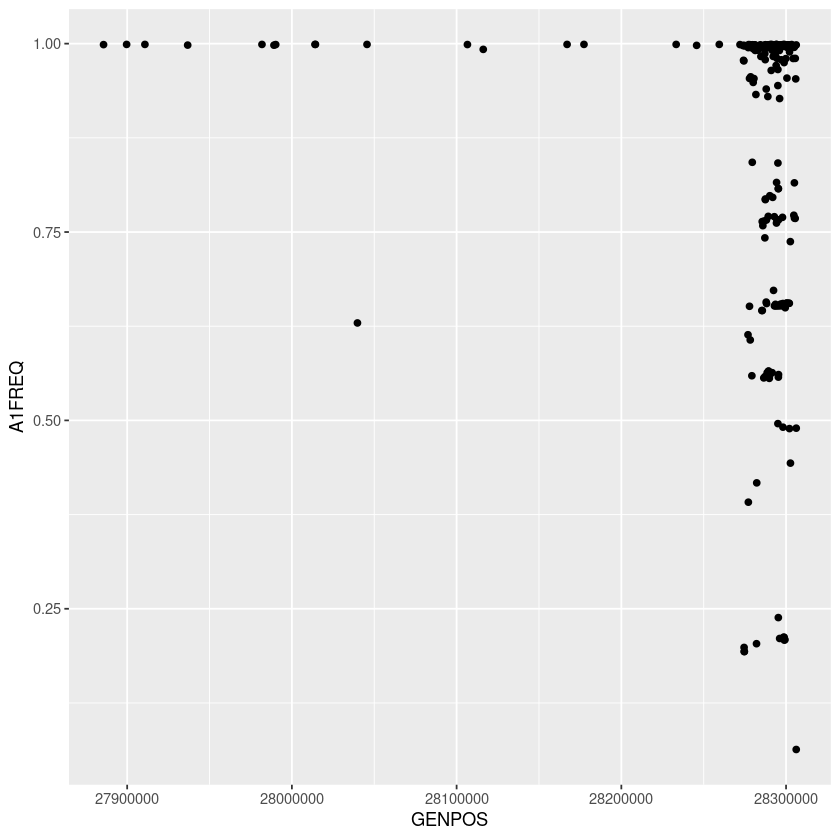

In [42]:
gwas%>%filter(!ID %in% GWAS_filtered$ID)%>%arrange(-LOG10P)%>%mutate(variant  = paste0(CHROM,"_",GENPOS,"_",ALLELE1,"_",ALLELE0 ))%>%ggplot(aes(x = GENPOS ) )+ geom_point(aes(y = A1FREQ))

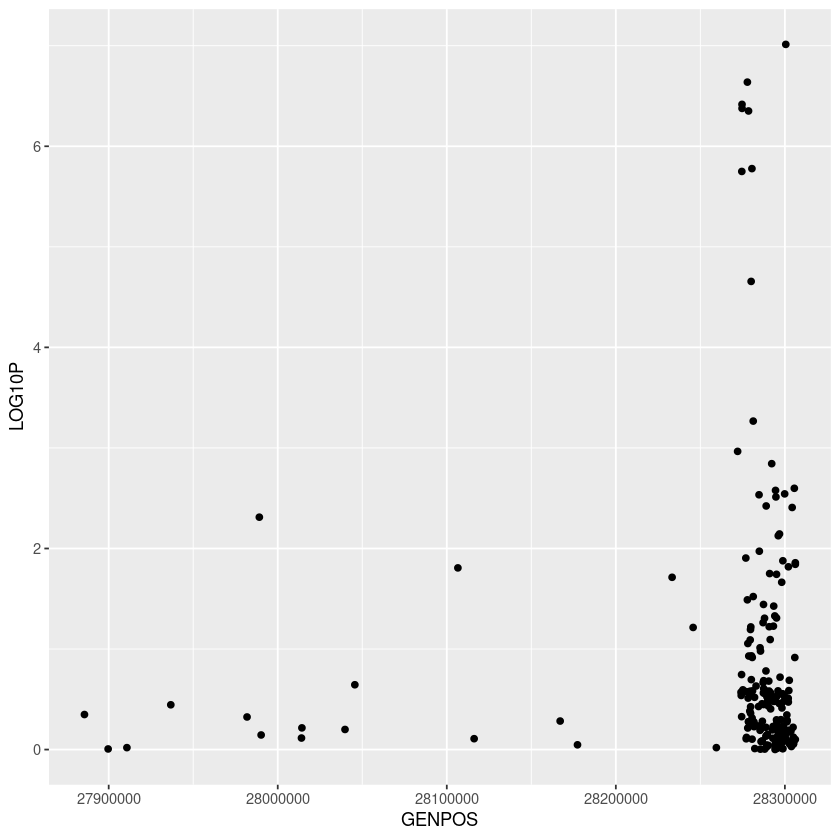

In [41]:
gwas%>%filter(!ID %in% GWAS_filtered$ID)%>%arrange(-LOG10P)%>%mutate(variant  = paste0(CHROM,"_",GENPOS,"_",ALLELE1,"_",ALLELE0 ))%>%ggplot(aes(x = GENPOS ) )+ geom_point(aes(y = LOG10P))

In [ ]:
#### Rerun with suff statistics

In [44]:
bhat = as.matrix(GWAS_filtered%>%pull(BETA))
sbhat =  as.matrix(GWAS_filtered%>%pull(SE))

In [61]:
res10_waist_rerun = susieR:::susie_rss(bhat = bhat , shat = sbhat ,
                                 R = new_LD_filtered,n = 365920  , estimate_residual_variance = TRUE, 
    prior_variance = 50, check_prior = F ,L = 10,verbose = TRUE, compute_univariate_zscore = TRUE , refine = T)

HINT: For estimate_residual_variance = TRUE, please check that R is the "in-sample" LD matrix; that is, the correlation matrix obtained using the exact same data matrix X that was used for the other summary statistics. Also note, when covariates are included in the univariate regressions that produced the summary statistics, also consider removing these effects from X before computing R.



[1] "objective:-518925.900679102"
[1] "objective:-518925.583774693"
[1] "objective:-518916.595576937"
[1] "objective:-518916.59487317"
[1] "objective:-518911.302084229"
[1] "objective:-518911.301967852"
[1] "objective:-518909.291087976"
[1] "objective:-518909.291074266"
[1] "objective:-518908.474641675"
[1] "objective:-518908.47463886"
[1] "objective:-518908.244119946"
[1] "objective:-518908.244119584"
[1] "objective:-518908.202465545"
[1] "objective:-518908.202465516"
[1] "objective:-518908.19493602"
[1] "objective:-518908.194936018"
[1] "objective:-518908.193235808"
[1] "objective:-518908.193235808"
[1] "objective:-518908.192770904"


In [62]:
res10_waist_rerun$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L3,1.0000000,1.0000000,1.0000000
L4,1.0000000,1.0000000,1.0000000
L6,1.0000000,1.0000000,1.0000000
L1,0.9839210,0.9906866,0.9875604
L5,0.9762961,0.9878110,0.9908655
L2,0.5655507,0.7948809,0.6962179


In [52]:
res10_waist$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L2,1.0000000,1.0000000,1.0000000
L5,1.0000000,1.0000000,1.0000000
L1,0.9839210,0.9906866,0.9875604
L4,0.9762961,0.9867972,0.9846997
L3,0.5655507,0.7948809,0.6962179


In [54]:
any(res10_waist_rerun$pip == res10_waist$pip)

[1] FALSE

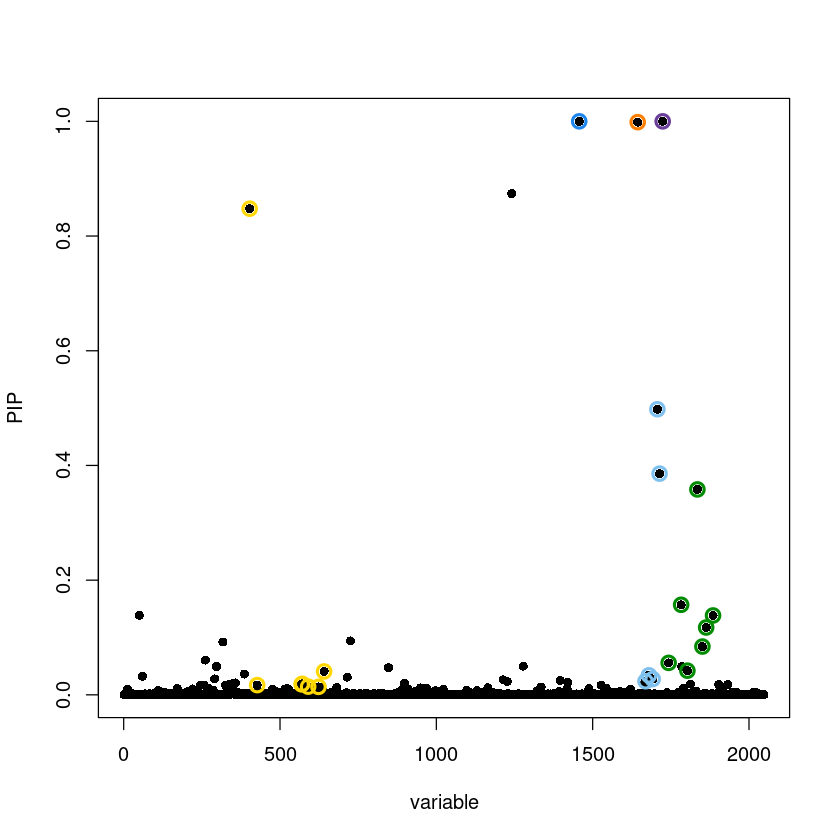

In [63]:
susie_plot(res10_waist_rerun, "PIP")

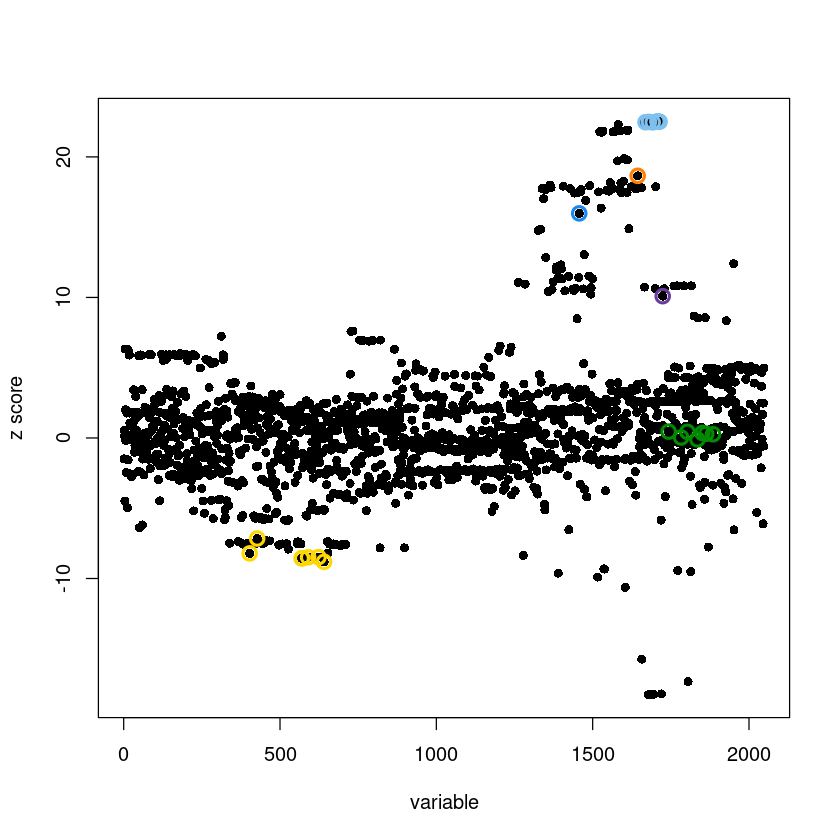

In [64]:
res10_waist_rerun$z = GWAS_filtered%>%pull(Z)
susie_plot(res10_waist_rerun, "z_original")

In [65]:
res10_waist_rerun_non_refine = susieR:::susie_rss(bhat = bhat , shat = sbhat ,
                                 R = new_LD_filtered,n = 365920  , estimate_residual_variance = TRUE, 
    prior_variance = 50, check_prior = F ,L = 10,verbose = TRUE, compute_univariate_zscore = TRUE )

HINT: For estimate_residual_variance = TRUE, please check that R is the "in-sample" LD matrix; that is, the correlation matrix obtained using the exact same data matrix X that was used for the other summary statistics. Also note, when covariates are included in the univariate regressions that produced the summary statistics, also consider removing these effects from X before computing R.



[1] "objective:-518925.900679102"
[1] "objective:-518925.583774693"
[1] "objective:-518916.595576937"
[1] "objective:-518916.59487317"
[1] "objective:-518911.302084229"
[1] "objective:-518911.301967852"
[1] "objective:-518909.291087976"
[1] "objective:-518909.291074266"
[1] "objective:-518908.474641675"
[1] "objective:-518908.47463886"
[1] "objective:-518908.244119946"
[1] "objective:-518908.244119584"
[1] "objective:-518908.202465545"
[1] "objective:-518908.202465516"
[1] "objective:-518908.19493602"
[1] "objective:-518908.194936018"
[1] "objective:-518908.193235808"
[1] "objective:-518908.193235808"
[1] "objective:-518908.192770904"


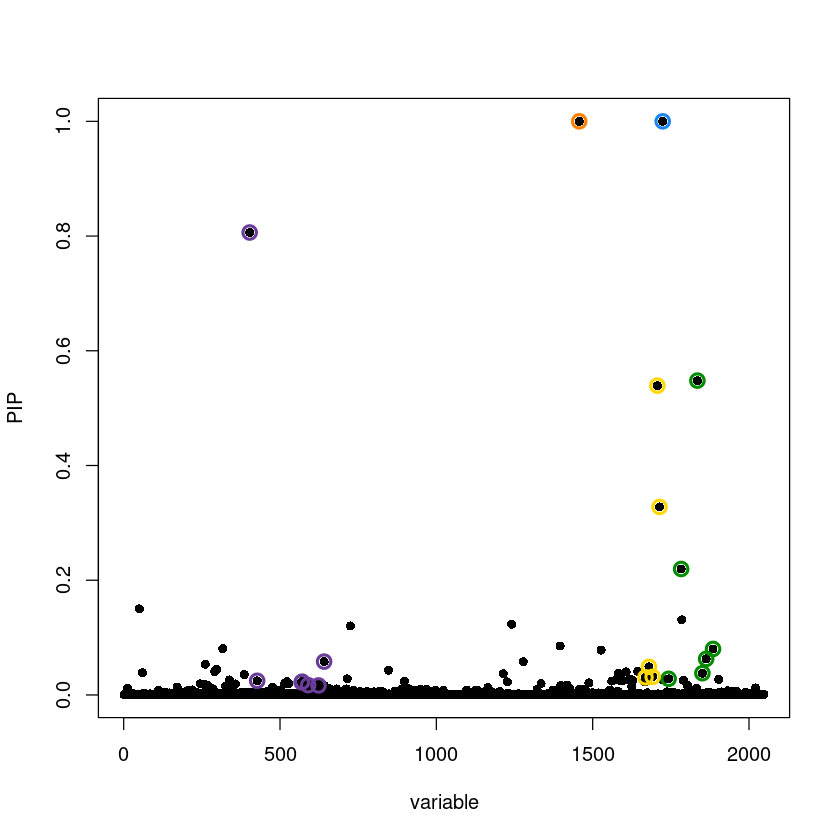

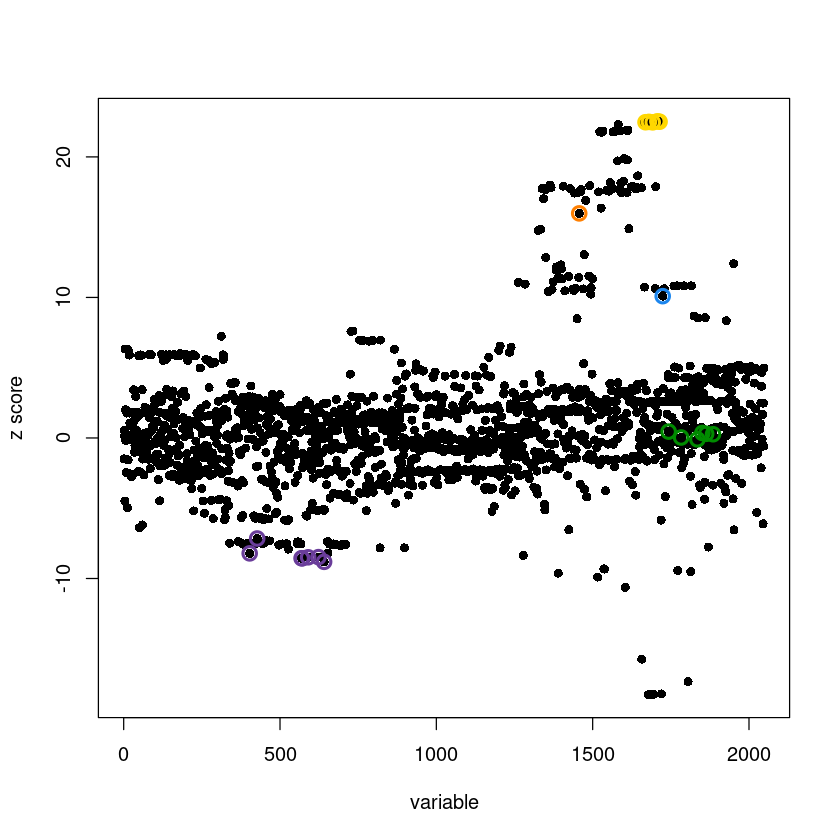

In [68]:
susie_plot(res10_waist_rerun_non_refine, "PIP")
res10_waist_rerun_non_refine$z = GWAS_filtered%>%pull(Z)
susie_plot(res10_waist_rerun_non_refine, "z_original")

[1] 1604 1657 1678 1688 1695 1720 1805

In [ ]:
#### Waist LD QC plot 

In [70]:
condz = susieR::kriging_rss(as.matrix(GWAS_filtered%>%pull(Z)) ,R = new_LD_filtered,n = 365920)

#### See where is the high Z  that are not in CS

In [ ]:
which(GWAS_filtered$Z %in%  (GWAS_filtered%>%filter(Z < -10))$Z)

In [86]:


p = ggplot(condz$conditional_dist, aes_string(y = "z", x = "condmean")) + geom_point() + 
        labs(y = "Observed z scores", x = "Expected value") + 
        geom_abline(intercept = 0, slope = 1) + theme_bw()
    idx = c(1604,1657,1678,1688,1695,1720,1805)
    if (length(idx) > 0) 
        p = p + geom_point(data = condz$conditional_dist[idx, ], aes_string(y = "z", 
            x = "condmean"), col = "red")

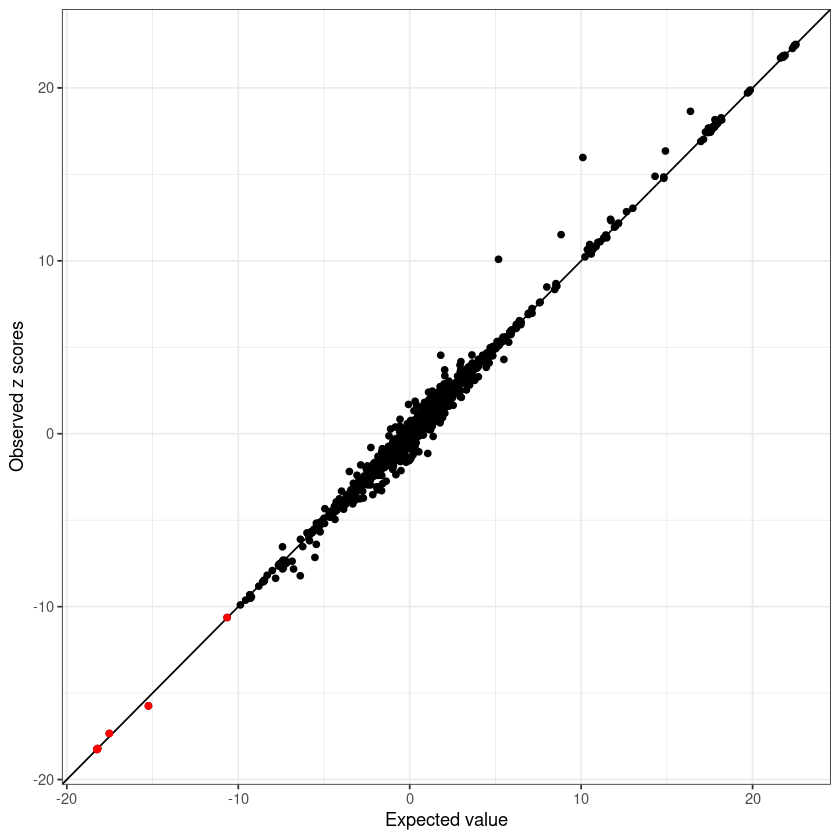

In [87]:
p

In [ ]:
#### See the LD of the hightlighted 

In [94]:
new_LD_filtered[c(1604,1657,1678,1688,1695,1720,1805), res10_waist_rerun$sets$cs$L5]

,7_28220228_T_C,7_28227024_A_G,7_28230401_C_A,7_28238811_G_A,7_28241276_G_A,7_28243473_G_A,7_28246989_G_A
7_28188046_A_C,-0.1438247,-0.1418293,-0.1435604,-0.1413670,-0.1432374,-0.1433002,-0.1433398
7_28200324_C_T,-0.1198626,-0.1170267,-0.1191613,-0.1169498,-0.1190787,-0.1188156,-0.1189458
7_28205138_G_C,-0.1487952,-0.1455810,-0.1469904,-0.1453467,-0.1479779,-0.1478341,-0.1479376
7_28206668_C_T,-0.1485278,-0.1453177,-0.1467278,-0.1450824,-0.1477121,-0.1475659,-0.1476755
7_28207784_A_G,-0.1485592,-0.1453448,-0.1467529,-0.1451129,-0.1477402,-0.1475962,-0.1477036
7_28213530_A_G,-0.1494639,-0.1468453,-0.1479619,-0.1462178,-0.1485422,-0.1487740,-0.1488889
7_28231103_T_C,-0.1511659,-0.1484653,-0.1510192,-0.1479063,-0.1504406,-0.1506815,-0.1508226


In [92]:
new_LD_filtered[c(1604,1657,1678,1688,1695,1720,1805), res10_waist_rerun$sets$cs$L2]

,7_27945054_C_CT,7_27949022_C_CA,7_27982312_A_C,7_27982633_A_C,7_27985368_T_C,7_27991924_G_C,7_27994758_C_T
7_28188046_A_C,0.04497646,-0.03067978,0.05280593,0.05271899,0.05300182,0.05352839,0.05702767
7_28200324_C_T,0.03889781,0.05190818,0.04697416,0.04704921,0.04699595,0.04617575,0.04657780
7_28205138_G_C,0.03754114,0.05546208,0.05766422,0.05766934,0.05679111,0.05603536,0.05950225
7_28206668_C_T,0.03751054,0.05509809,0.05756182,0.05756923,0.05668832,0.05593158,0.05939947
7_28207784_A_G,0.03733439,0.05492651,0.05747806,0.05748009,0.05659992,0.05584929,0.05931407
7_28213530_A_G,0.03760291,0.05491675,0.05724929,0.05728415,0.05637860,0.05562851,0.05923380
7_28231103_T_C,0.03813424,0.05514225,0.05740496,0.05742219,0.05657585,0.05580112,0.05934832


In [96]:
new_LD_filtered[c(1604,1657,1678,1688,1695,1720,1805), res10_waist_rerun$sets$cs$L1]

,7_28203142_T_C,7_28205303_C_T,7_28207300_T_G,7_28210660_C_T,7_28212824_C_T
7_28188046_A_C,-0.6298969,-0.6295271,-0.6288748,-0.6247857,-0.6239123
7_28200324_C_T,-0.5266182,-0.5263625,-0.5257240,-0.5215563,-0.5204246
7_28205138_G_C,-0.6517138,-0.6513777,-0.6505541,-0.6457562,-0.6425622
7_28206668_C_T,-0.6509243,-0.6506042,-0.6500722,-0.6452318,-0.6420599
7_28207784_A_G,-0.6506574,-0.6503206,-0.6498404,-0.6452299,-0.6439474
7_28213530_A_G,-0.6452822,-0.6449918,-0.6444793,-0.6473064,-0.6437795
7_28231103_T_C,-0.6165873,-0.6163041,-0.6158517,-0.6184030,-0.6172483


In [95]:
new_LD_filtered[c(1604,1657,1678,1688,1695,1720,1805), c(res10_waist_rerun$sets$cs$L3,res10_waist_rerun$sets$cs$L4,res10_waist_rerun$sets$cs$L6 )]

,7_28197805_CACACAG_C,7_28214614_C_A,7_28159795_G_GT
7_28188046_A_C,-0.4044334,-0.2104333,0.05735555
7_28200324_C_T,-0.3393821,-0.1769121,-0.41772950
7_28205138_G_C,-0.4207897,-0.2185265,-0.50068301
7_28206668_C_T,-0.4203068,-0.2182654,-0.50112510
7_28207784_A_G,-0.4200498,-0.2197752,-0.49996263
7_28213530_A_G,-0.4153030,-0.2189582,-0.49585664
7_28231103_T_C,-0.3923382,-0.2083391,-0.49056581


In [99]:
GWAS_filtered%>%filter(Z < -12)

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,variant,Z
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>
7,28200324,rs73091214,C,T,0.893509,0.977700,365920,ADD,-0.0352128,0.00223654,247.883,55.1240,NA,7_28200324_C_T,-15.74432
7,28205138,rs73091220,G,C,0.848774,0.999036,365920,ADD,-0.0348317,0.00190664,333.744,73.8327,NA,7_28205138_G_C,-18.26863
7,28206668,rs76491048,C,T,0.848915,0.998997,365920,ADD,-0.0347635,0.00190749,332.142,73.4837,NA,7_28206668_C_T,-18.22474
7,28207784,rs150231034,A,G,0.849051,0.999127,365920,ADD,-0.0348108,0.00190812,332.827,73.6329,NA,7_28207784_A_G,-18.24351
7,28213530,rs113598422,A,G,0.847854,0.996083,365920,ADD,-0.0346974,0.00190497,331.756,73.3997,NA,7_28213530_A_G,-18.21415
7,28231103,rs57871463,T,C,0.844042,0.984847,365920,ADD,-0.0328799,0.00189633,300.633,66.6201,NA,7_28231103_T_C,-17.33870


### 2. Check correlation of CS between Hight_5(L4) with other CS

In [97]:
get_cs_correlation(res10_waist_rerun,Xcorr = new_LD_filtered )

,L3,L4,L6,L1,L5,L2
L3,1.00000000,-0.089923881,0.34157416,0.63241333,-0.09149425,-0.046376299
L4,-0.08992388,1.000000000,0.07125106,0.32550335,0.52575368,0.006262631
L6,0.34157416,0.071251057,1.00000000,0.34625262,0.07895993,0.013319202
L1,0.63241333,0.325503349,0.34625262,1.00000012,0.22524266,-0.064054720
L5,-0.09149425,0.525753677,0.07895993,0.22524266,1.00000000,0.025586858
L2,-0.04637630,0.006262631,0.01331920,-0.06405472,0.02558686,1.000000119


In [101]:
res10_waist_conditional_analysis = susieR:::susie_rss(bhat = bhat , shat = sbhat ,
                                 R = new_LD_filtered,n = 365920  , estimate_residual_variance = TRUE, 
    prior_variance = 50, check_prior = F ,L = 10,verbose = TRUE, compute_univariate_zscore = TRUE, max_iter = 1)

HINT: For estimate_residual_variance = TRUE, please check that R is the "in-sample" LD matrix; that is, the correlation matrix obtained using the exact same data matrix X that was used for the other summary statistics. Also note, when covariates are included in the univariate regressions that produced the summary statistics, also consider removing these effects from X before computing R.



[1] "objective:-518925.900679102"
[1] "objective:-518925.583774693"


Warning message in susie_suff_stat(XtX = XtX, Xty = Xty, n = n, yty = (n - 1) * :
“IBSS algorithm did not converge in 1 iterations!
                  Please check consistency between summary statistics and LD matrix.
                  See https://stephenslab.github.io/susieR/articles/susierss_diagnostic.html”


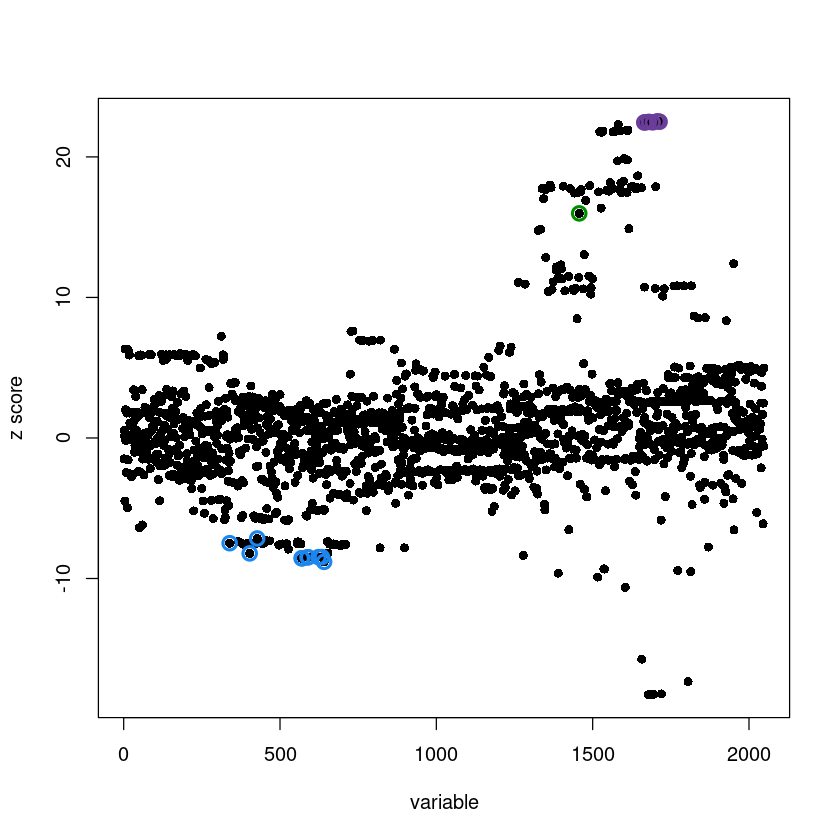

In [104]:
res10_waist_conditional_analysis$z = GWAS_filtered%>%pull(Z)
susie_plot(res10_waist_conditional_analysis,"z_original")

In [34]:
gwas%>%filter(!ID %in% GWAS_filtered$ID)%>%arrange(-LOG10P)%>%mutate(variant  = paste0(CHROM,"_",GENPOS,"_",ALLELE1,"_",ALLELE0 ))%>%pull(A1FREQ)%>%ggplot(aes(x = ) )+ 

0%       25%       50%       75%      100% 
0.0632659 0.7503065 0.9923670 0.9979640 0.9989940

In [26]:
gwas%>%filter(!ID %in% GWAS_filtered$ID)%>%arrange(-LOG10P)%>%mutate(variant  = paste0(CHROM,"_",GENPOS,"_",ALLELE1,"_",ALLELE0 ))%>%filter(variant %in% colnames(new_LD))

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,variant
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>


In [32]:
gwas%>%filter(GENPOS %in% read.table(text = colnames(new_LD), sep = "_")$V2)

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
7,27869098,rs545409685,C,T,0.997338,0.921920,365920,ADD,-0.020502500,0.01379330,2.2094100,0.8627390,NA
7,27869261,7:27869261_CAGTA_C,C,CAGTA,0.998504,0.847013,365920,ADD,0.010340600,0.01922140,0.2894120,0.2287080,NA
7,27869377,rs73075348,G,A,0.943403,1.000000,365920,ADD,0.000331266,0.00295709,0.0125495,0.0405750,NA
7,27869782,rs6948467,A,G,0.607201,0.993109,365920,ADD,-0.006316580,0.00140366,20.2508000,5.1679800,NA
7,27869794,rs73075354,G,C,0.883848,0.994221,365920,ADD,0.013539200,0.00213971,40.0388000,9.6038500,NA
7,27869921,rs35410592,A,C,0.990574,0.967843,365920,ADD,0.014456400,0.00719418,4.0379100,1.3517500,NA
7,27870389,rs183893860,G,A,0.997424,0.939441,365920,ADD,-0.002618450,0.01391080,0.0354312,0.0702262,NA
7,27870716,rs75940382,T,C,0.990173,0.976199,365920,ADD,-0.017327800,0.00701361,6.1038700,1.8700300,NA
7,27870845,rs185104866,C,G,0.998640,0.978154,365920,ADD,0.003053000,0.01876370,0.0264737,0.0601071,NA


In [27]:
gwas%>%filter(!ID %in% GWAS_filtered$ID)%>%arrange(-LOG10P)%>%mutate(variant  = paste0(CHROM,"_",GENPOS,"_",ALLELE0,"_",ALLELE1 ))%>%filter(variant %in% colnames(new_LD))

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,variant
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
